In [3]:
import conifer
import datetime
import pickle
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

def open_model(filename):
    """ Returns sklearn stored in pickle file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

def synth_model(model, bit_width='ap_fixed<18,8>'):
    """ Return conifer model given scikit model """
    # Create a conifer config
    cfg = conifer.backends.vivadohls.auto_config()

    # Set the output directory to something unique
    cfg['OutputDir'] = 'prj_{}'.format(int(datetime.datetime.now().timestamp()))
    cfg['XilinxPart'] = 'xc7vx690tffg1761-2'
    cfg['Precision'] = bit_width
    
    # Create and compile the model
    conif_model = conifer.model(model, conifer.converters.sklearn, conifer.backends.vhdl, cfg)
    conif_model.compile()
     
    # Synthesize the model
    conif_model.build()

    return conif_model

def load_params_used(filename):
    with open(filename, "r") as f:
        return f.read().split()

def load_data(sig_filename, bg_filename, features):
    """ Returns datafram, X, Y for data stored in csv file"""
    
    sig_df = pd.read_csv(sig_filename)[features]
    bg_df = pd.read_csv(bg_filename)[features]
    
    sig_df["signal"] = 1
    bg_df["signal"] = 0
    
    df  = pd.concat([sig_df, bg_df], ignore_index=True)
    
    X = df.to_numpy()[:, :-1]
    Y = df.to_numpy()[:, -1][np.newaxis].transpose()
    
    return df, X, Y

def split_data(X, Y, test_percent=0.1):
    """ Returns X_train, Y_train, X_test, Y_test """
    total = np.concatenate((X, Y), axis=1)
    np.random.shuffle(total)
    n_X = (int) ((1 - test_percent) * total.shape[0])
    
    X_train = total[:n_X, :-1]
    X_test = total[n_X:, :-1]
    
    Y_train = total[:n_X, -1][np.newaxis].transpose()
    Y_test = total[n_X:, -1][np.newaxis].transpose()
    
    return X_train, Y_train, X_test, Y_test

def get_stats(model, X, Y):
    """ 
    Returns false positive rates, true positive rates, 
    and area under curve for given model. 
    """
    Y_pred = model.decision_function(X)
    fpr, tpr, _ = sklearn.metrics.roc_curve(Y, Y_pred)
    auc = sklearn.metrics.auc(fpr, tpr) 
    return dict(zip(["fpr", "tpr", "auc"], [fpr, tpr, auc]))

def make_plot(
    results, 
    colors=['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'],
    linewidth=2,
    plots_folder='plot.png'
    ):
    """
    Results is a dictionary where the key is the name of the model and the value is a
    dictionary with the keys fpr, tpr, auc. Plots these results with pretty colors.
    """
    plt.figure()
 
    c = 0
    for name, stats in results.items():
        plt.plot(stats["fpr"], stats["tpr"], color=colors[c], 
            lw=linewidth, label=f"{name} (area = {stats['auc']})")
        c = (c + 1) % len(colors)
 
    #plt.semilogy()
    plt.xlim([0.0, 1.0])
    #plt.ylim([1e-3, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    plt.title('ROC Curves for BDT Tau Lepton Classifier')
    plt.legend(loc="upper left")
    plt.savefig(plots_folder, bbox_inches='tight')
    plt.show()
    
### int_bit determined by max tree threshold determined
### by running conif_model.profile()
def get_auc_ratios(grad_model, X_test, Y_test, int_bit, end_bit):
    sklearn_stats = get_stats(grad_model, X_test, Y_test) 

    bit_widths = []
    auc_ratios = []
    aucs = []

    for i in range(int_bit, end_bit):
        bw = '<{},{}>'.format(i, int_bit)
        bit_widths.append(bw)
        conif_model = synth_model(grad_model, 'ap_fixed' + bw)
        conif_stats = get_stats(conif_model, X_test, Y_test)
        auc_ratios.append(conif_stats["auc"]/sklearn_stats["auc"])
        aucs.append(conif_stats["auc"])
        
    return bit_widths, auc_ratios, aucs

def plot_auc_ratios(auc_ratios, bit_widths):
    plt.scatter(bit_widths, auc_ratios)
    plt.title('Conifer Model Bit Width Profile')
    plt.xlabel('Fixed Point Bit Width <Total Bit Width, Integer Width>')
    plt.ylabel('Conifer AUC/Sklearn AUC')
    plt.xticks(rotation=45)

def load_split_data(data="./ScaledData"):
    res = []
    for i in ("X_train", "Y_train", "X_test", "Y_test"):
        res.append(np.load(f"{data}/{i}.npy"))
    return res[0], res[1], res[2], res[3]

### Load the scaled model and scaled data

In [7]:
X_train, Y_train, X_test, Y_test = load_split_data()

grad_model = open_model('scaled_100_4_model.pkl')

### Determine AUC ratios for Sklearn model and Conifer Models of various bitwidths

In [9]:
## change int_bit=10 argument to the best value as determined by 
## running .profile() on a conifer model (the lower the better).
bit_widths, auc_ratios, aucs = get_auc_ratios(grad_model, X_test, Y_test, 10, 20)

### Plot the Ratios

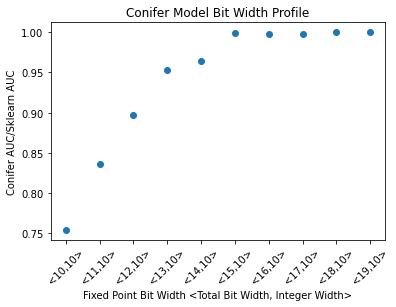

In [10]:
plot_auc_ratios(auc_ratios, bit_widths)